# Age of Empires 2 game records analysis

Importing modules needed

In [1]:
import sys
import glob, os
from datetime import datetime as dt
from mgz import header, body
from mgz.summary import Summary
import json
from mgz.model import parse_match, serialize
import json
import re
import pandas as pd
from functools import reduce
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn 
import math

os.chdir("C:\\Users\\kardo\\Games\\Age of Empires 2 DE\\76561198861901568\\savegame")

Importing files to be parsed, those are personal game replay files (381 of them at the time of this writing) and involve Multiplayer (online) 1 versus 1 games

In [2]:
list_of_files = glob.glob("*.aoe2record")
len(list_of_files)
list_of_files[-5:] # showing last five records

['MP Replay v101.102.8319.0 #(73855) @2022.12.08 104819 (2).aoe2record',
 'MP Replay v101.102.8319.0 #(73855) @2022.12.08 114046 (1).aoe2record',
 'MP Replay v101.102.8319.0 #(73855) @2022.12.08 120821 (1).aoe2record',
 'MP Replay v101.102.8319.0 #(73855) @2022.12.08 124146 (2).aoe2record',
 'MP Replay v101.102.8319.0 #(73855) @2022.12.08 125748 (2).aoe2record']

So here there are a varierty of headers (from json) within which things ranging from 'research' (a given tech was researched), to 'move' - in this case included in the 'actions' key/header. 
The main focus in this next section will be on focusing on 'follow' keystroke which involves a scout (to which both players have access at the very start of the game) to lure deer into the Town Center/starting base for additional 'free' source of food.

In [15]:
matches = []
json_obj = []

for file in list_of_files:
    try: 
        with open(str(file), 'rb') as rec:
            matches.append(json.dumps(serialize(parse_match(rec)))) 
    except Exception:
                pass

for dumps in matches:
    json_obj.append(json.loads(dumps))

len(json_obj)
[len(x) for x in matches]


# player actions 
def actions_taken(json_obj):
	actions_taken = json_obj['actions']
	str_conv = str(actions_taken)
	dict_conv = eval(str_conv)
	return dict_conv

# players identification
def players_(json_obj):
	players = json_obj['players']
	str_conv = str(players)
	dict_conv = eval(str_conv)
	return dict_conv

actions = []
for game_files in json_obj:
    actions.append(actions_taken(game_files))

players = []
for game_files in json_obj:
    players.append(players_(game_files))

# generating multiple dataframes from json to get cleaner values and later run analysis
def from_json_to_df(x):

    df = []
    for games_played in x:
        df.append(pd.json_normalize(games_played)) 
    return df

dfs_with_player_mappings = []

for left, right in zip(from_json_to_df(actions), from_json_to_df(players)):
      dfs_with_player_mappings.append( pd.merge(left, right, how = 'left', left_on = 'player', right_on = 'number') )


deer_pushed_cnt = []
won_game_cnt = []
eapm = []
wessex_civ = []

def counting_intentional_deer_pushes(x):

    ttl_deer_pushed = games['payload.target_id'].loc[( games['type'] == 'FOLLOW' )\
             & ( games['name'] == 'AofWessex' )].groupby(games['payload.target_id']).count()
    mask = ttl_deer_pushed > 3        
    return len(ttl_deer_pushed.loc[mask])

for games in dfs_with_player_mappings:

    try:
        deer_pushed_cnt.append(counting_intentional_deer_pushes(games))
    except Exception:
                pass

    won_game_cnt.append(games['winner'].loc[( games['winner'] == True )\
         & ( games['name'] == 'AofWessex' )].drop_duplicates().count())

    eapm.append(games['eapm'].loc[( games['name'] == 'AofWessex' )].drop_duplicates().min())
    
    wessex_civ.append(games['civilization'].loc[( games['name'] == 'AofWessex' )].drop_duplicates().min())
    

overall_stats_df = pd.DataFrame(list(zip(deer_pushed_cnt, eapm, wessex_civ, won_game_cnt)),\
    columns = ['deer_pushed_ttl', 'eapm', 'civ', 'won_game'])


KeyboardInterrupt: 

In [4]:
overall_stats_df

,deer_pushed_ttl,eapm,civ,won_game
0,0,42.0,Incas,0
1,0,45.0,Incas,0
2,0,45.0,Burmese,1
3,0,55.0,Burmese,1
4,0,46.0,Burmese,0
...,...,...,...,...
360,0,41.0,Vikings,0
361,1,50.0,Portuguese,0
362,1,53.0,Britons,1
363,0,63.0,Burmese,1


first filtering to games with apm >= 20 as it will filter out games where replay files failed to be parsed out,  due to minor/major game patches (usually older files will have this issue) this also filters out very short game (early resign from myself or from opponenent because of things such as not being a  fan of a given map generated, etc.)

In [9]:

overall_stats_df_filtered = overall_stats_df[overall_stats_df['eapm'] >= 20]


Does eapm contribute to higher win chances ?

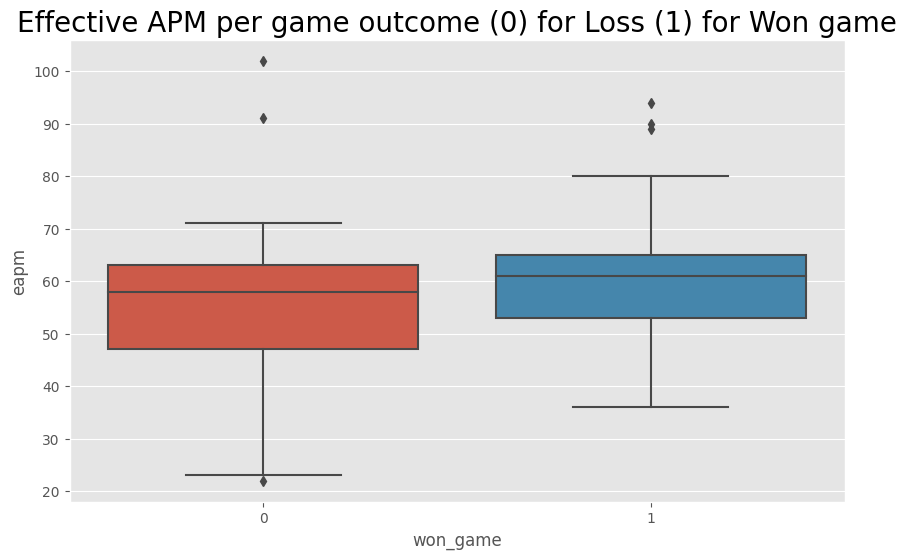

In [10]:
fig, ax = plt.subplots(dpi = 100, figsize = (10, 6))
plt.style.use('ggplot')
with seaborn.plotting_context(rc={"font.size":20,"axes.titlesize":20,"axes.labelsize":20}):
    seaborn.boxplot(x = 'won_game', y = 'eapm', data = overall_stats_df_filtered)\
        .set_title('Effective APM per game outcome (0) for Loss (1) for Won game')        


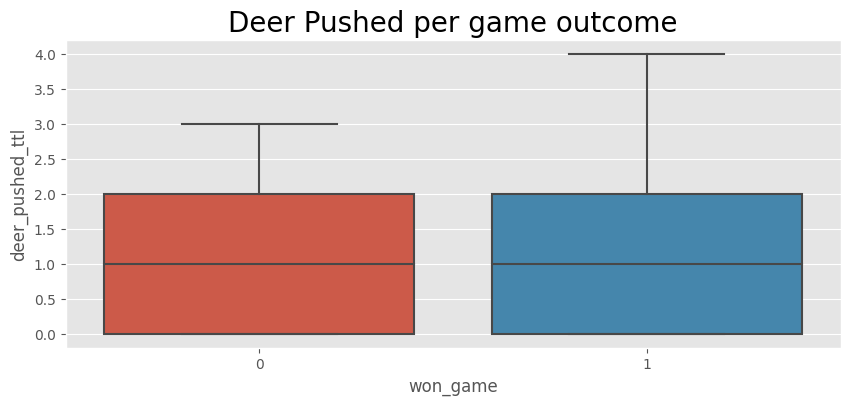

In [11]:
fig, ax = plt.subplots(dpi = 100, figsize = (10, 4))
plt.style.use('ggplot')
with seaborn.plotting_context(rc={"font.size":20,"axes.titlesize":20,"axes.labelsize":20}):
    seaborn.boxplot(x = 'won_game', y = 'deer_pushed_ttl', data = overall_stats_df_filtered)\
        .set_title('Deer Pushed per game outcome')        


from above, we can clearly see that pushing deer (along with no. of deer pushed/lured to base) does not have an impact of winning the game

looking at overall loss/win rates per civilization played (not accounting for opponent choice of civilization)

In [12]:
overall_win_rates_per_civ = (
    pd.crosstab(index = [overall_stats_df_filtered.civ],
        columns = [overall_stats_df_filtered.won_game],
        margins = True,\
        normalize= 'index')\
        .round(4)*100
) 

overall_win_rates_per_civ = overall_win_rates_per_civ.merge(
    overall_stats_df_filtered.groupby(['civ']).count().iloc[:, -1], left_on='civ', right_on='civ'
)

overall_win_rates_per_civ.rename(columns={0: 'loss_rate', 1: 'win_rate', 'won_game': 'no_of_games'}, inplace = True)
overall_win_rates_per_civ


,loss_rate,win_rate,no_of_games
civ,,,
Aztecs,80.00,20.00,5
Bengalis,57.14,42.86,7
Berbers,33.33,66.67,3
Britons,42.86,57.14,7
Bulgarians,57.14,42.86,7
Burgundians,66.67,33.33,6
Burmese,45.83,54.17,144
Byzantines,33.33,66.67,6
Celts,0.00,100.00,2


<AxesSubplot: xlabel='None-None', ylabel='civ'>

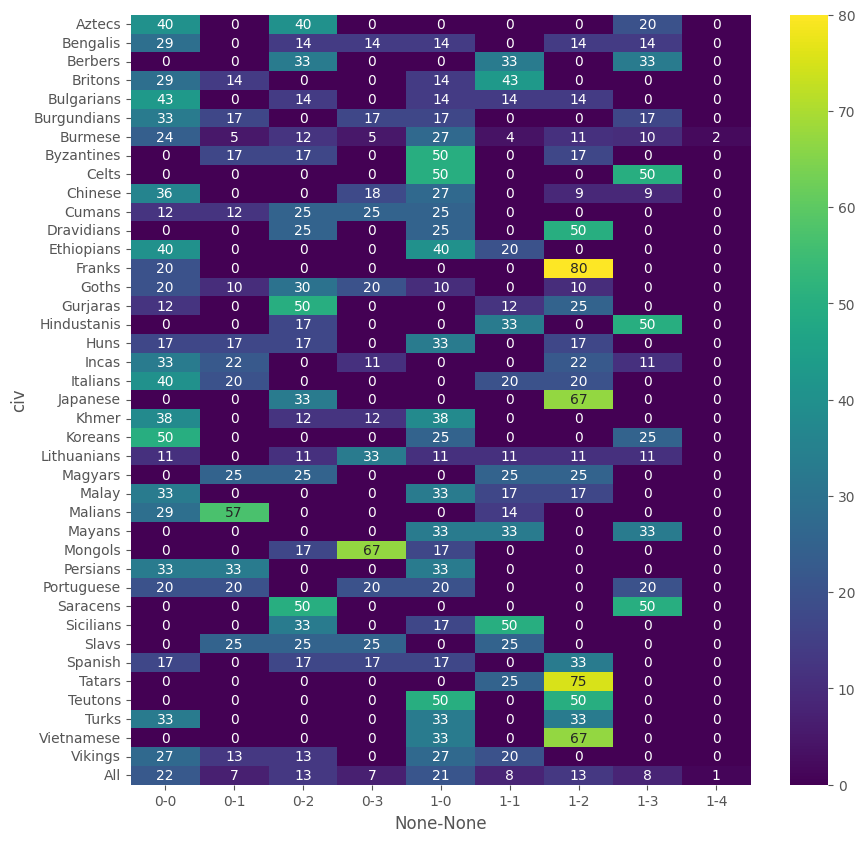

In [91]:

civ_win_rates_per_deer_pushed_bin = pd.crosstab(index = [overall_stats_df_filtered.civ],
    columns = [overall_stats_df_filtered.won_game, overall_stats_df_filtered.deer_pushed_ttl],
    margins = True,
    normalize = 'index')\
    .mul(100)\
    .round(2)

civ_win_rates_per_deer_pushed_bin.columns = civ_win_rates_per_deer_pushed_bin.columns.rename(names = ['Loss/Win Rate %', 'No. of Deer Pushed'])
idx = pd.MultiIndex.from_tuples(civ_win_rates_per_deer_pushed_bin.columns, names = ['Loss', 'Win'])
civ_win_rates_per_deer_pushed_bin.columns = civ_win_rates_per_deer_pushed_bin.columns.to_flat_index()


fig, ax = plt.subplots(dpi = 100, figsize = (10, 10))
plt.style.use('ggplot')

seaborn.heatmap(round(civ_win_rates_per_deer_pushed_bin, 0),\
    annot = True, fmt = "g", cmap = 'viridis')



In [24]:
civ_win_rates_per_deer_pushed_bin

won_game             0                           1                           
deer_pushed_ttl      0      1      2      3      0      1      2      3     4
civ                                                                          
Aztecs           40.00   0.00  40.00   0.00   0.00   0.00   0.00  20.00  0.00
Bengalis         28.57   0.00  14.29  14.29  14.29   0.00  14.29  14.29  0.00
Berbers           0.00   0.00  33.33   0.00   0.00  33.33   0.00  33.33  0.00
Britons          28.57  14.29   0.00   0.00  14.29  42.86   0.00   0.00  0.00
Bulgarians       42.86   0.00  14.29   0.00  14.29  14.29  14.29   0.00  0.00
Burgundians      33.33  16.67   0.00  16.67  16.67   0.00   0.00  16.67  0.00
Burmese          23.61   4.86  12.50   4.86  27.08   4.17  11.11   9.72  2.08
Byzantines        0.00  16.67  16.67   0.00  50.00   0.00  16.67   0.00  0.00
Celts             0.00   0.00   0.00   0.00  50.00   0.00   0.00  50.00  0.00
Chinese          36.36   0.00   0.00  18.18  27.27   0.00   9.09   9.09  0.00
Cumans           12.50  12.50  25.00  25.00  25.00   0.00   0.00   0.00  0.00
Dravidians        0.00   0.00  25.00   0.00  25.00   0.00  50.00   0.00  0.00
Ethiopians       40.00   0.00   0.00   0.00  40.00  20.00   0.00   0.00  0.00
Franks           20.00   0.00   0.00   0.00   0.00   0.00  80.00   0.00  0.00
Goths            20.00  10.00  30.00  20.00  10.00   0.00  10.00   0.00  0.00
Gurjaras         12.50   0.00  50.00   0.00   0.00  12.50  25.00   0.00  0.00
Hindustanis       0.00   0.00  16.67   0.00   0.00  33.33   0.00  50.00  0.00
Huns             16.67  16.67  16.67   0.00  33.33   0.00  16.67   0.00  0.00
Incas            33.33  22.22   0.00  11.11   0.00   0.00  22.22  11.11  0.00
Italians         40.00  20.00   0.00   0.00   0.00  20.00  20.00   0.00  0.00
Japanese          0.00   0.00  33.33   0.00   0.00   0.00  66.67   0.00  0.00
Khmer            37.50   0.00  12.50  12.50  37.50   0.00   0.00   0.00  0.00
Koreans          50.00   0.00   0.00   0.00  25.00   0.00   0.00  25.00  0.00
Lithuanians      11.11   0.00  11.11  33.33  11.11  11.11  11.11  11.11  0.00
Magyars           0.00  25.00  25.00   0.00   0.00  25.00  25.00   0.00  0.00
Malay            33.33   0.00   0.00   0.00  33.33  16.67  16.67   0.00  0.00
Malians          28.57  57.14   0.00   0.00   0.00  14.29   0.00   0.00  0.00
Mayans            0.00   0.00   0.00   0.00  33.33  33.33   0.00  33.33  0.00
Mongols           0.00   0.00  16.67  66.67  16.67   0.00   0.00   0.00  0.00
Persians         33.33  33.33   0.00   0.00  33.33   0.00   0.00   0.00  0.00
Portuguese       20.00  20.00   0.00  20.00  20.00   0.00   0.00  20.00  0.00
Saracens          0.00   0.00  50.00   0.00   0.00   0.00   0.00  50.00  0.00
Sicilians         0.00   0.00  33.33   0.00  16.67  50.00   0.00   0.00  0.00
Slavs             0.00  25.00  25.00  25.00   0.00  25.00   0.00   0.00  0.00
Spanish          16.67   0.00  16.67  16.67  16.67   0.00  33.33   0.00  0.00
Tatars            0.00   0.00   0.00   0.00   0.00  25.00  75.00   0.00  0.00
Teutons           0.00   0.00   0.00   0.00  50.00   0.00  50.00   0.00  0.00
Turks            33.33   0.00   0.00   0.00  33.33   0.00  33.33   0.00  0.00
Vietnamese        0.00   0.00   0.00   0.00  33.33   0.00  66.67   0.00  0.00
Vikings          26.67  13.33  13.33   0.00  26.67  20.00   0.00   0.00  0.00
All              21.80   7.08  13.08   7.36  21.25   7.90  12.81   7.90  0.82